In [1]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding
import networkx as nx

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar,StellarGraph
from stellargraph import datasets
from IPython.display import display, HTML
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, HinSAGE, link_classification

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
import pandas as pd
import numpy as np
%matplotlib inline

In [31]:
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt

import data

In [2]:
g1 = nx.read_graphml("2019-12-31.graphml")
g2 = nx.read_graphml("2020-01-01.graphml")

In [3]:
def max_min_normalization(G):
    n_tx = nx.get_edge_attributes(G, "n_tx")
    value = nx.get_edge_attributes(G, "value")
    weight = {}
    n_tx_min = min(n_tx.values())
    n_tx_max = max(n_tx.values())
    value_min = min(value.values())
    value_max = max(value.values())
    for key in n_tx.keys():
        n_tx[key] = (n_tx[key] - n_tx_min)/(n_tx_max - n_tx_min)
    for key in value.keys():
        value[key] = (value[key] - value_min)/(value_max - value_min)
    for key in value.keys():
        weight[key] = n_tx[key] * 0.5 + value[key] * 0.5
    weight_min = min(weight.values())
    weight_max = max(weight.values())
    for key in weight.keys():
        weight[key] = (weight[key] - weight_min)/(weight_max - weight_min)
    nx.set_edge_attributes(G, weight, name="weight")
    return weight

In [4]:
g2.remove_nodes_from(list(n for n in g2 if n not in g1))

In [5]:
g2.number_of_nodes()

43417

In [6]:
g2.number_of_edges()

46496

In [7]:
max_min_normalization(g2)

{('92780875', '117464570'): 0.0330883588327742,
 ('92780875', '90418301'): 6.501721822443546e-09,
 ('92780875', '21056449'): 6.430270702341098e-09,
 ('92780875', '98506467'): 0.005514731890230552,
 ('92780875', '11803180'): 0.0018382481549891587,
 ('92780875', '454659861'): 6.501721822443546e-09,
 ('117464570', '40204445'): 6.430270702341098e-09,
 ('117464570', '360268312'): 0.0018382482978913988,
 ('19470293', '23582560'): 2.8807659301836146e-06,
 ('19470293', '447603521'): 7.886690947161198e-06,
 ('19470293', '2427613'): 0.005995443711262052,
 ('19470293', '43952585'): 0.0018480426388072422,
 ('19470293', '16403130'): 0.0018798741961725228,
 ('19470293', '35077956'): 1.2604807881404207e-06,
 ('19470293', '406479316'): 1.2216712185009657e-05,
 ('23582560', '23364610'): 0.09316234096751069,
 ('2427613', '52861266'): 0.0018704105786745938,
 ('2427613', '21056449'): 0.2681309458201957,
 ('2427613', '45050929'): 0.007363803092058816,
 ('2427613', '447538986'): 0.0004044626288140988,
 ('24

In [8]:
dc = nx.degree_centrality(g2)

In [10]:
def compute_features(node_id):
    # in general this could compute something based on other features, but for this example,
    # we don't have any other features, so we'll just do something basic with the node_id
    return [dc[node_id]]

for node_id, node_data in g2.nodes(data=True):
    node_data["feature"] = compute_features(node_id)

In [11]:
Gs = StellarGraph.from_networkx(
    g2
    ,node_features="feature"
)

In [12]:
print(Gs.info())

StellarDiGraph: Directed multigraph
 Nodes: 43417, Edges: 46496

 Node types:
  default: [43417]
    Features: float32 vector, length 1
    Edge types: default-default->default

 Edge types:
    default-default->default: [46496]
        Weights: range=[0, 1], mean=0.00204027, std=0.0175599
        Features: none


In [13]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(Gs)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=False
)

** Sampled 4649 positive and 4649 negative edges. **


In [14]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=False
)

** Sampled 4184 positive and 4184 negative edges. **


In [15]:
print(G_train.info())

StellarDiGraph: Directed multigraph
 Nodes: 43417, Edges: 37663

 Node types:
  default: [43417]
    Features: float32 vector, length 1
    Edge types: default-default->default

 Edge types:
    default-default->default: [37663]
        Weights: range=[6.50774e-15, 0.971131], mean=0.00199415, std=0.0169274
        Features: none


In [16]:
print(G_test.info())

StellarDiGraph: Directed multigraph
 Nodes: 43417, Edges: 41847

 Node types:
  default: [43417]
    Features: float32 vector, length 1
    Edge types: default-default->default

 Edge types:
    default-default->default: [41847]
        Weights: range=[0, 0.971131], mean=0.00199694, std=0.0167132
        Features: none


In [17]:
batch_size = 10
epochs = 10
num_samples = [10, 5]

In [18]:
train_gen = GraphSAGELinkGenerator(G_train, batch_size, num_samples)
train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True)

In [19]:
test_gen = GraphSAGELinkGenerator(G_test, batch_size, num_samples)
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

In [20]:
layer_sizes = [10, 10]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.3
)

In [21]:
# Build the model and expose input and output sockets of graphsage model
# for link prediction
x_inp, x_out = graphsage.in_out_tensors()

/Users/liminghao/miniconda3/envs/stellar/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [22]:
prediction = link_classification(
    output_dim=1, output_act="relu", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [23]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=["acc"],
)

In [24]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

2023-07-28 12:40:02.286133: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


930/930 [==============================] - 4s 4ms/step - loss: 3.3961 - acc: 0.6213

Train Set Metrics of the initial (untrained) model:
	loss: 3.4268
	acc: 0.6309

Test Set Metrics of the initial (untrained) model:
	loss: 3.3961
	acc: 0.6213


In [25]:
history = model.fit(train_flow, epochs=epochs, validation_data=test_flow, verbose=2)

Epoch 1/10
837/837 - 7s - loss: 1.1618 - acc: 0.5380 - val_loss: 2.8564 - val_acc: 0.5426 - 7s/epoch - 8ms/step
Epoch 2/10
837/837 - 6s - loss: 0.9421 - acc: 0.5513 - val_loss: 2.7859 - val_acc: 0.5482 - 6s/epoch - 7ms/step
Epoch 3/10
837/837 - 7s - loss: 0.9172 - acc: 0.5461 - val_loss: 2.9334 - val_acc: 0.5416 - 7s/epoch - 8ms/step
Epoch 4/10
837/837 - 6s - loss: 1.0254 - acc: 0.5075 - val_loss: 3.8292 - val_acc: 0.5000 - 6s/epoch - 7ms/step
Epoch 5/10
837/837 - 6s - loss: 0.9166 - acc: 0.5073 - val_loss: 3.4954 - val_acc: 0.5000 - 6s/epoch - 7ms/step
Epoch 6/10
837/837 - 6s - loss: 0.8795 - acc: 0.5191 - val_loss: 3.2353 - val_acc: 0.4992 - 6s/epoch - 7ms/step
Epoch 7/10
837/837 - 6s - loss: 0.8728 - acc: 0.5295 - val_loss: 3.1446 - val_acc: 0.4995 - 6s/epoch - 7ms/step
Epoch 8/10
837/837 - 5s - loss: 0.9034 - acc: 0.5413 - val_loss: 4.2623 - val_acc: 0.5000 - 5s/epoch - 6ms/step
Epoch 9/10
837/837 - 6s - loss: 1.0281 - acc: 0.5087 - val_loss: 3.5452 - val_acc: 0.5000 - 6s/epoch - 7

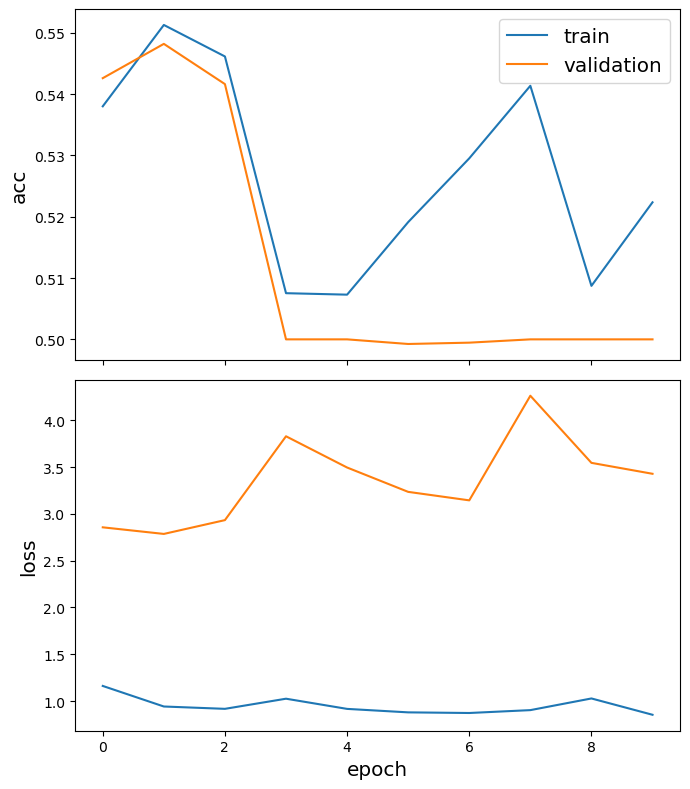

In [28]:
pra = sg.utils.plot_history(history, return_figure=True)

In [30]:
type(pra)

matplotlib.figure.Figure

In [35]:
pra.savefig('test.png')

In [27]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

930/930 [==============================] - 3s 4ms/step - loss: 3.4237 - acc: 0.5000

Train Set Metrics of the trained model:
	loss: 3.6308
	acc: 0.5000

Test Set Metrics of the trained model:
	loss: 3.4237
	acc: 0.5000
